In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import os
import cv2
from DataClasses import TextData, CircleData, MalenNachZahlenPunkt
import numpy as np
import pytesseract
from pytesseract import Output
from matplotlib import pyplot as plt

In [2]:
def imshow(imgs, figsize=(12.5, 10), **kwargs):
    """ Utility function for dispalying an array of images. """
    if not isinstance(imgs, list): imgs = [imgs]
    cols = int(np.ceil(np.sqrt(len(imgs))))
    rows = cols-1 if (cols*cols-len(imgs)== cols) else cols
    fig, axs = plt.subplots(rows, cols, figsize=figsize, squeeze=False)
    for img, ax in zip(imgs, axs.flatten()): 
        cm, sl = ('gray', np.s_[:, :]) if img.ndim == 2 else (None, np.s_[...,::-1])
        ax.imshow(img[sl], cmap=cm, **kwargs)
    for ax in axs.flatten(): ax.axis('off')
    plt.tight_layout()

In [3]:
#def write_aruco_marker(out_dir, aruco_dict):
#    """ Write images of the markers with id 0,1,2,3 to the specified dir. """
#    path_frmt = os.path.join(out_dir, '{id}-4x4-50.png')
#    os.makedirs(markers_dir, exist_ok=True)

#    for i in range(4):
#        img = cv2.aruco.drawMarker(ar_dict, i, 500)
#        cv2.imwrite(path_frmt.format(id=i), img)
        
ar_dict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_4X4_50)
#markers_dir = os.path.expanduser('~/Desktop/aruco_marker')
#write_aruco_marker(markers_dir, ar_dict)

In [4]:
cm_img = cv2.imread('/Users/eugenrogulenko/UniProjects/projektseminar-regelungstechnik/data/test-images/test-color-2.jpg')
cm_img_gray = cv2.cvtColor(cm_img, cv2.COLOR_BGR2GRAY)

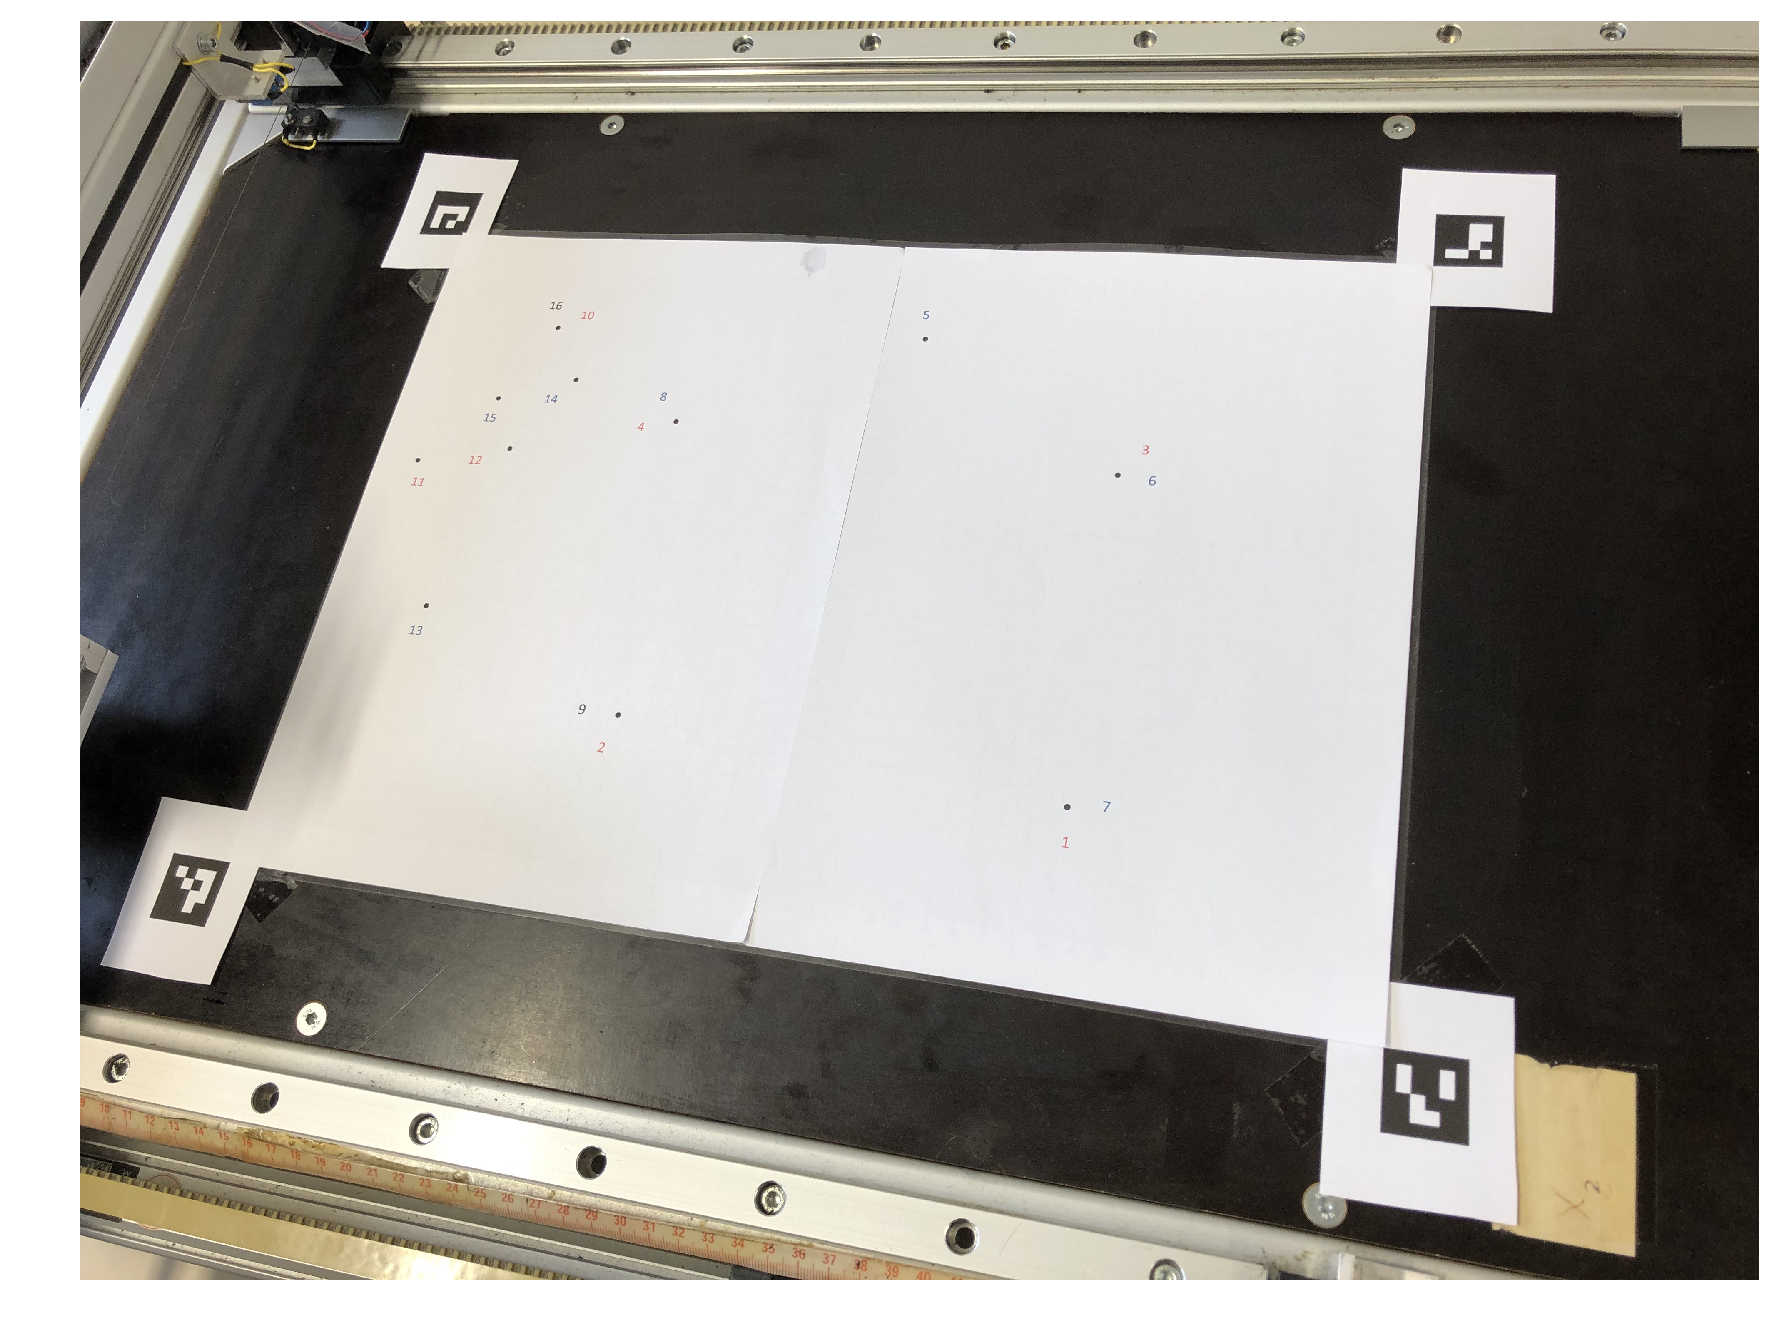

In [5]:
imshow(cm_img)

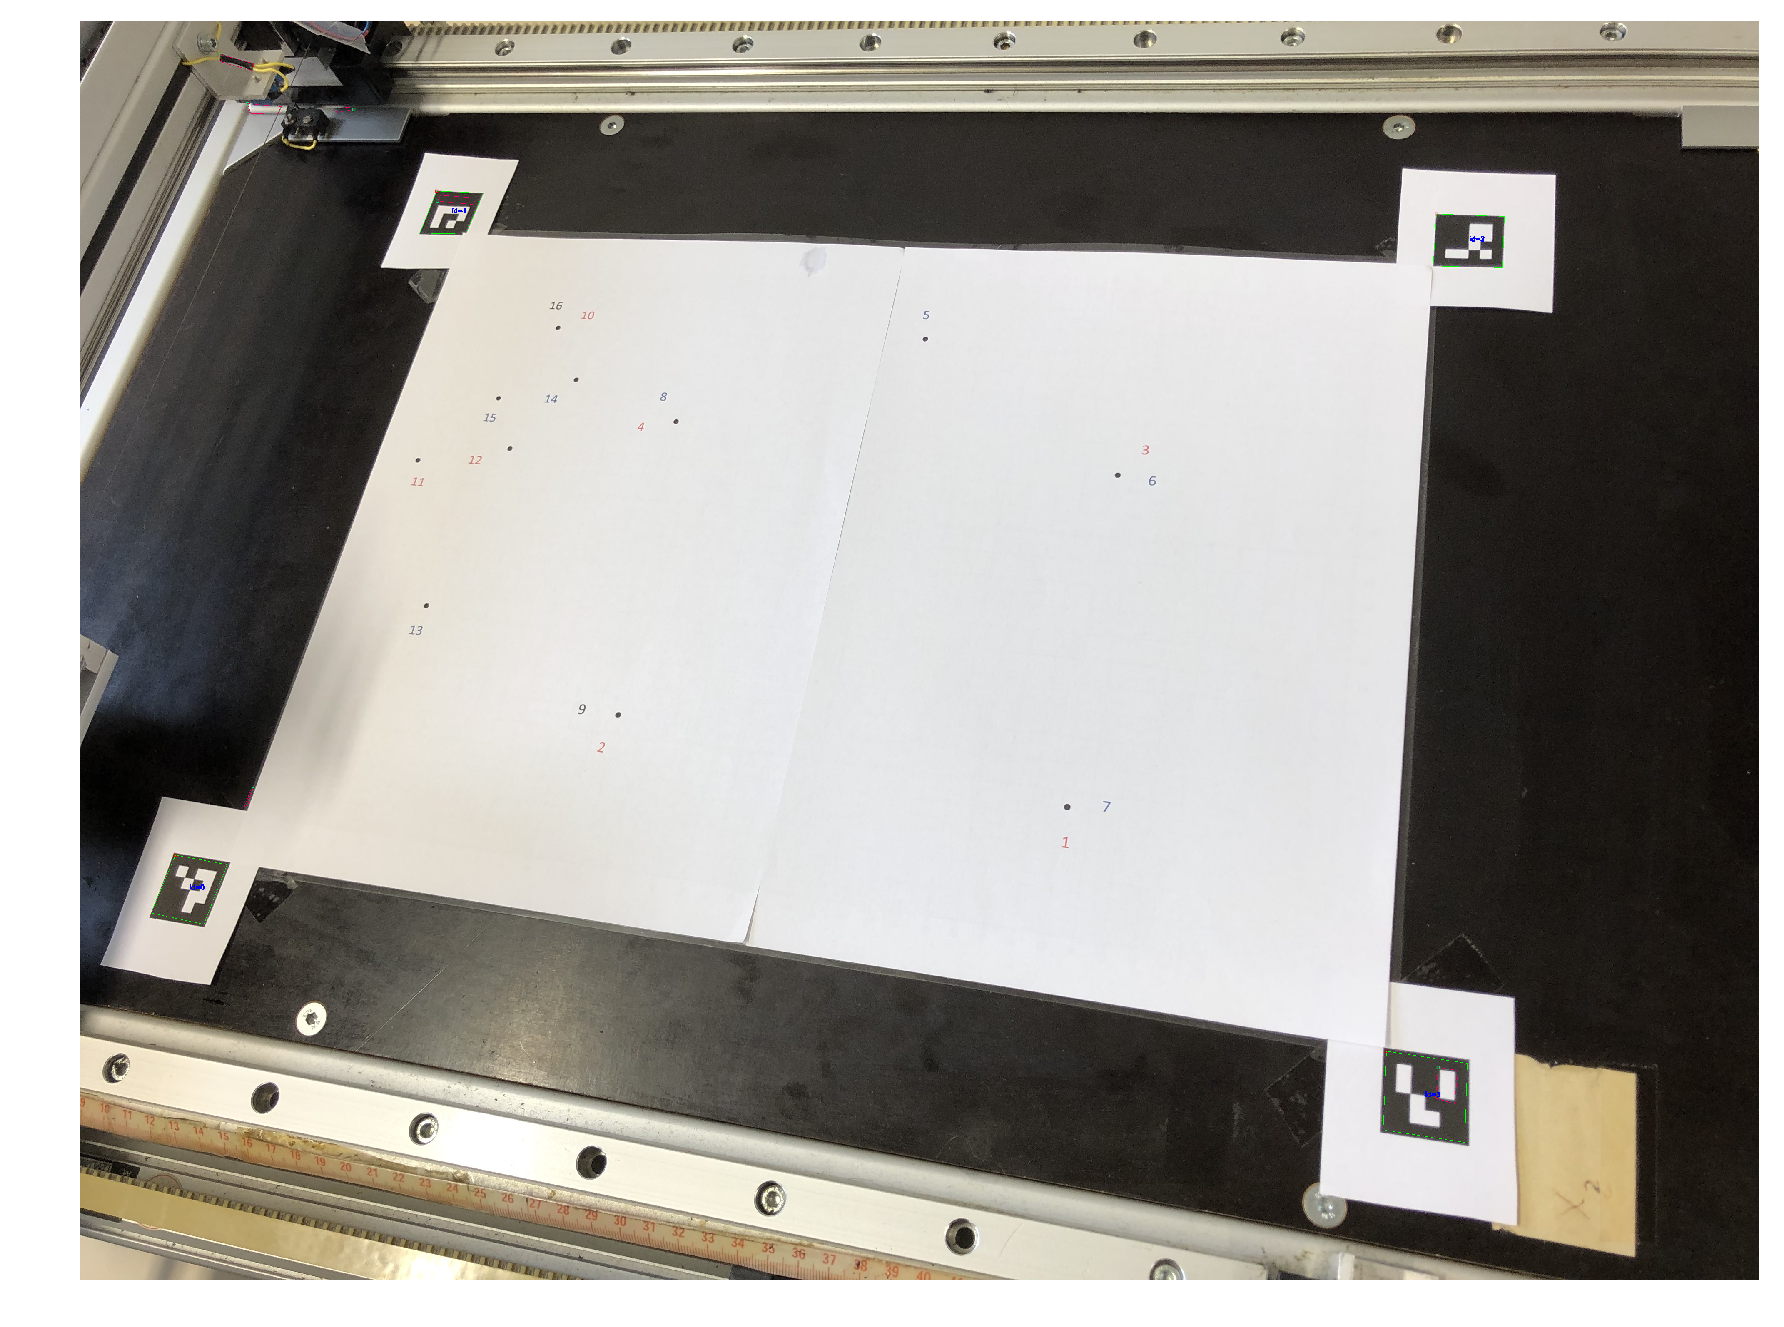

In [6]:
parameters =  cv2.aruco.DetectorParameters_create()
parameters.cornerRefinementMethod = cv2.aruco.CORNER_REFINE_SUBPIX
corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(cm_img_gray, ar_dict, parameters=parameters)
frame_markers = cv2.aruco.drawDetectedMarkers(cm_img.copy(), corners, ids)
frame_markers = cv2.aruco.drawDetectedMarkers(frame_markers, rejectedImgPoints, borderColor=(100, 0, 240))

imshow(frame_markers)

In [7]:
corners

[array([[[ 3137.,  2474.],
         [ 3331.,  2503.],
         [ 3325.,  2693.],
         [ 3129.,  2663.]]], dtype=float32),
 array([[[  229.        ,  2003.        ],
         [  353.        ,  2026.        ],
         [  297.        ,  2169.        ],
         [  170.30288696,  2142.1574707 ]]], dtype=float32),
 array([[[ 856.26300049,  407.57861328],
         [ 968.1786499 ,  413.19750977],
         [ 927.27642822,  508.77755737],
         [ 814.73291016,  511.28488159]]], dtype=float32),
 array([[[ 3256.58789062,   463.34295654],
         [ 3420.3828125 ,   468.54858398],
         [ 3415.85498047,   592.02514648],
         [ 3249.34057617,   588.45916748]]], dtype=float32)]

In [8]:
ids

array([[3],
       [0],
       [1],
       [2]], dtype=int32)

In [9]:
h,w = cm_img_gray.shape
middle = np.float32([h/2, w/2])
ids2point = {}

for mid, m_corners in zip(np.squeeze(ids), np.squeeze(corners)):
    ds = np.sqrt(np.sum((m_corners-middle)**2, axis=1)) # distance of corner points to center of image
    ids2point[mid] = m_corners[np.argmin(ds)]

In [10]:
width, height = 2*21.0, 29.7 # size of area marked by inner points of aruco markers in cm
dst_h, dst_w = int(height*50), int(width*50) 

src_pts = np.array([ids2point[i] for i in range(4)])
dst_pts = np.array([[0, dst_h],
                    [0, 0],
                    [dst_w, 0],
                    [dst_w, dst_h]], dtype="float32")

M = cv2.getPerspectiveTransform(src_pts, dst_pts)

In [11]:
warped = cv2.warpPerspective(cm_img_gray, M, (dst_w, dst_h))

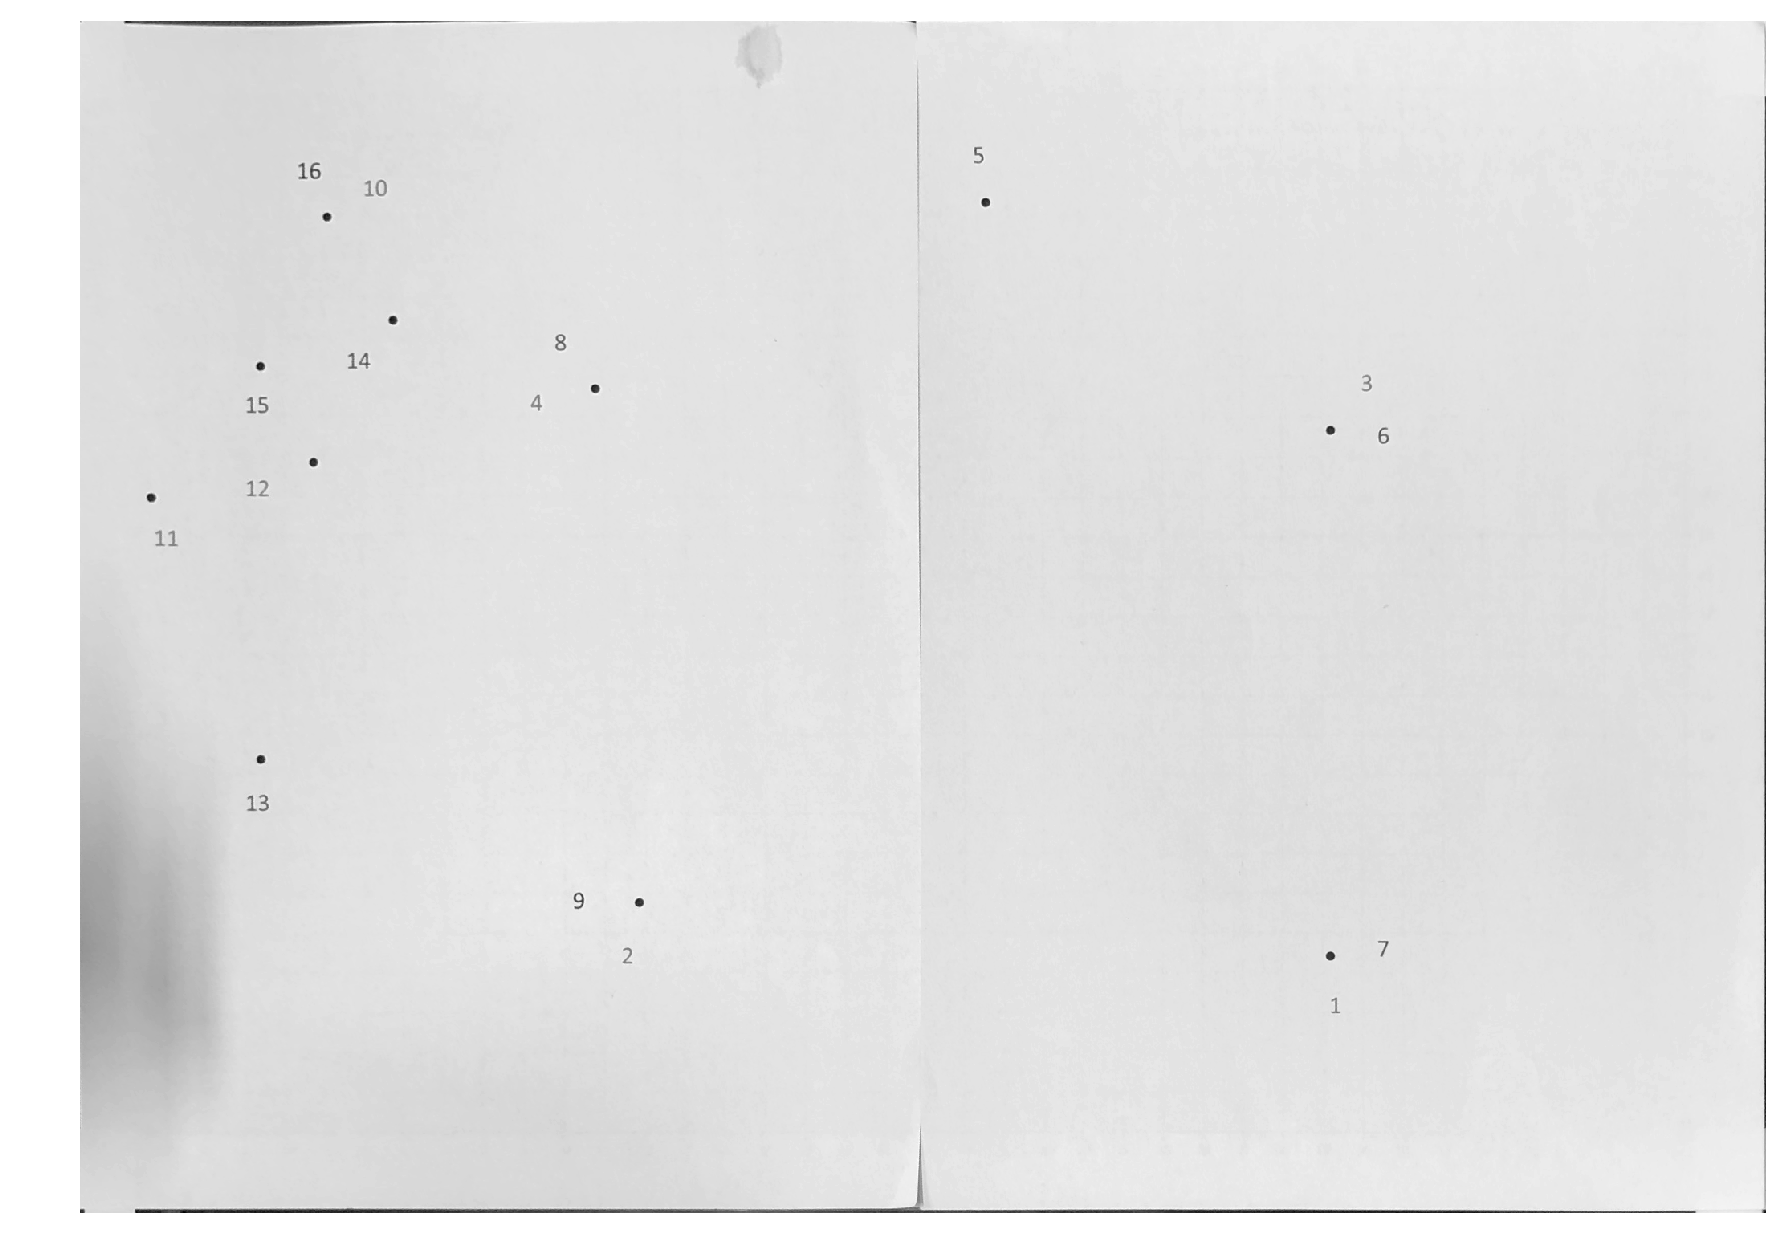

In [12]:
imshow(warped)

In [13]:
circles = cv2.HoughCircles(cv2.GaussianBlur(warped, (5, 5), 2.), cv2.HOUGH_GRADIENT, 1., 
                           minDist=10, param1=100, param2=15, 
                           minRadius=0, maxRadius=dst_w//100)[0]

# draw detections
res_img = cv2.cvtColor(warped.copy(), cv2.COLOR_GRAY2BGR)
circleData = []
for x, y, r in circles.astype(np.int):
    
    Y, X = np.ogrid[:warped.shape[0], :warped.shape[1]]
    mask = np.sqrt((X - x)**2 + (Y - y)**2) <= r
    
    # only accept circles that are mostly filled with black
    if np.median(warped[mask]) < 120: 
        circleData.append(CircleData(x, y, r))

In [14]:
# https://github.com/tesseract-ocr/tesseract/wiki/ImproveQuality
#  4     Assume a single column of text of variable sizes.
#  6     Assume a single uniform block of text.
#  11    Sparse text. Find as much text as possible in no particular order.
testData = pytesseract.image_to_data(warped, config='-c tessedit_char_whitelist=0123456789 --psm 6 --oem 0', output_type=Output.DICT)
h, w, _ = res_img.shape

textData = []
n_boxes = len(testData['level'])
for i in range(n_boxes):
    text = testData['text'][i]
    if text != u'' and text != u'0':
        (x, y, w, h) = (testData['left'][i], testData['top'][i], testData['width'][i], testData['height'][i])
        textData.append(TextData(text, x, y, w, h))

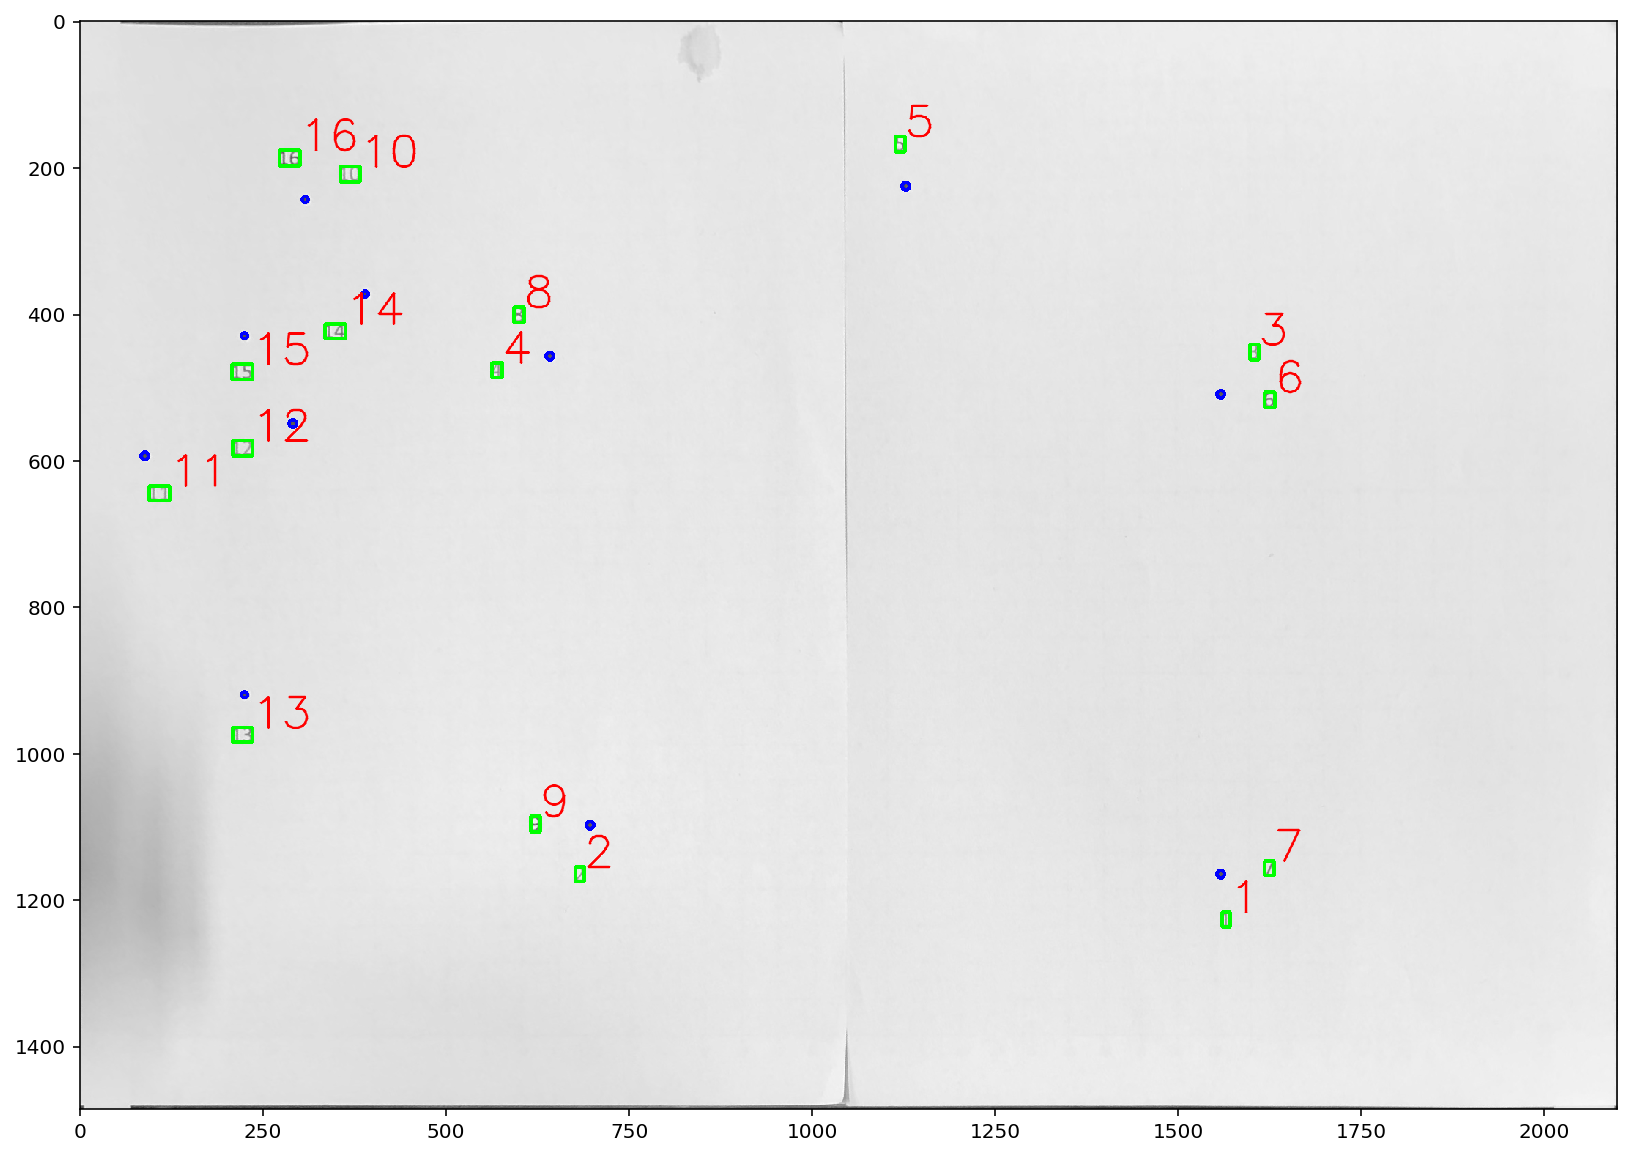

In [15]:
for c in circleData:
    cv2.circle(res_img, (c.x, c.y), c.r, (0, 0, 255), 4)
for t in textData:
    cv2.putText(res_img, t.text, (t.x + t.w, t.y), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 2, cv2.LINE_AA)
    cv2.rectangle(res_img, (t.x, t.y), (t.x + t.w, t.y + t.h), (0, 255, 0), 4)

plt.figure(figsize=(20, 10))
plt.imshow(res_img)

In [16]:
recognized_points = []
for t in textData:
    min_distance = None
    nearest_circle = None
    for c in circleData:
        cur_distance = np.sqrt((t.mid_x - c.x)**2 + (t.mid_y - c.y) **2)
        if min_distance is None or cur_distance < min_distance:
            min_distance = cur_distance
            nearest_circle = c
    recognized_points.append(MalenNachZahlenPunkt(int(t.text), 1, nearest_circle.x, nearest_circle.y))

recognized_points.sort(key=lambda p: p.num_id)
for p in recognized_points:
    print(p)

(Number: 1 Color: 1 x: 1557 y: 1164
(Number: 2 Color: 1 x: 696 y: 1097
(Number: 3 Color: 1 x: 1557 y: 509
(Number: 4 Color: 1 x: 641 y: 457
(Number: 5 Color: 1 x: 1127 y: 225
(Number: 6 Color: 1 x: 1557 y: 509
(Number: 7 Color: 1 x: 1557 y: 1164
(Number: 8 Color: 1 x: 641 y: 457
(Number: 9 Color: 1 x: 696 y: 1097
(Number: 10 Color: 1 x: 307 y: 243
(Number: 11 Color: 1 x: 88 y: 593
(Number: 12 Color: 1 x: 290 y: 549
(Number: 13 Color: 1 x: 224 y: 919
(Number: 14 Color: 1 x: 389 y: 372
(Number: 15 Color: 1 x: 224 y: 429
(Number: 16 Color: 1 x: 307 y: 243


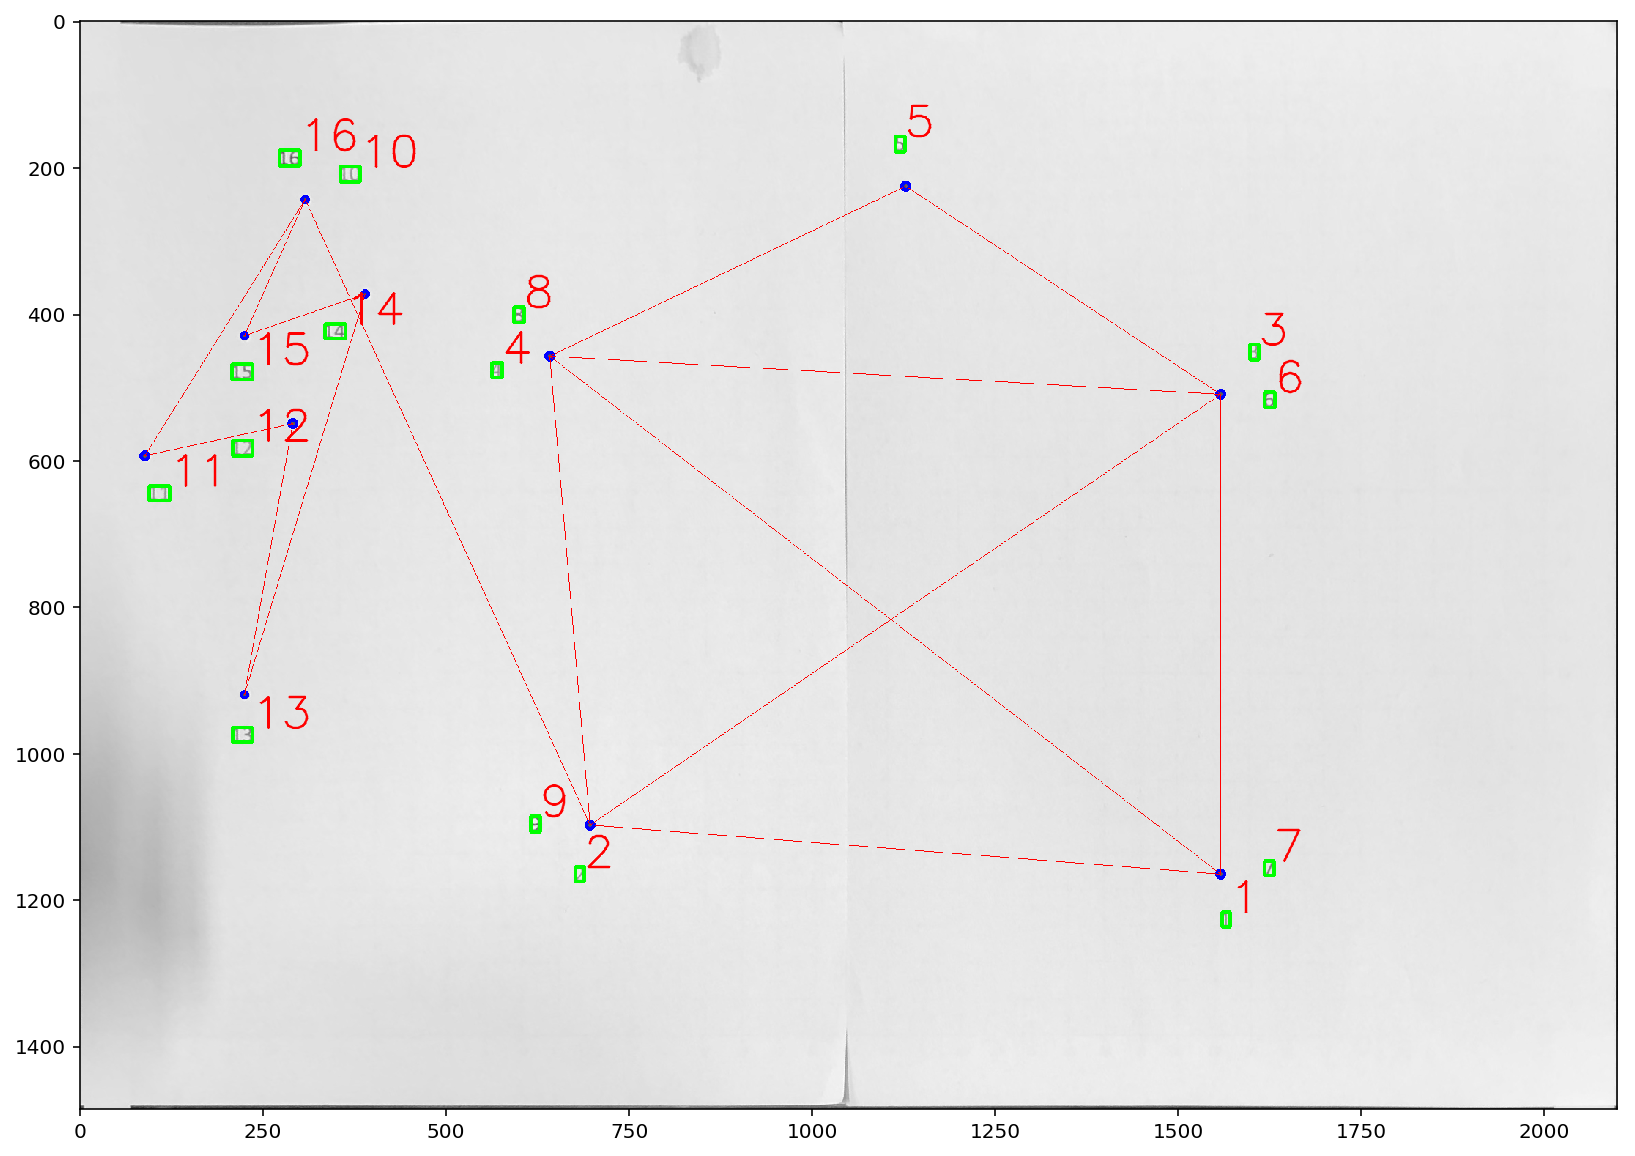

In [17]:
for i in range(len(recognized_points)):
    if i != len(recognized_points) - 1:
        p1 = recognized_points[i]
        p2 = recognized_points[i + 1]
        cv2.line(res_img, (p1.x, p1.y), (p2.x, p2.y), (255, 0, 0))
        
plt.figure(figsize=(20, 10))
plt.imshow(res_img)